In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from astropy.time import Time
from astropy.coordinates import Distance
from astropy import units as u
import numpy as np
from astropy.cosmology import WMAP9 as cosmo

In [2]:
base_dir = Path().absolute()
data_dir = os.path.join(base_dir, "data")

In [3]:
t_peak_mjd = Time(58603.87, format="mjd")
t_neutrino = Time("2019-10-01T20:09:18.17", format='isot', scale='utc')

bran_z = 0.0512

xpath = os.path.join(data_dir, "BranStark.dat")
# with open(xpath, "r") as f:
#     print(f.read())

In [4]:
df = pd.read_table(xpath, skiprows=4, sep="\s+")
print(df)

     #day_since_peak   band   flux_Jy       nu_rest           lum  \
0           15.54514   UVW2  0.000517  1.569084e+15  9.392264e+43   
1           19.23147   UVW2  0.000463  1.569084e+15  8.409503e+43   
2           22.20333   UVW2  0.000422  1.569084e+15  7.669557e+43   
3           25.16893   UVW2  0.000411  1.569084e+15  7.460541e+43   
4           28.24098   UVW2  0.000411  1.569084e+15  7.460541e+43   
..               ...    ...       ...           ...           ...   
191         34.81478  r.ZTF  0.000159  4.961606e+14  5.833004e+42   
192         38.61815  r.ZTF  0.000151  4.961606e+14  5.556640e+42   
193         44.28862  r.ZTF  0.000145  4.961606e+14  5.302641e+42   
194         47.13955  r.ZTF  0.000138  4.961606e+14  5.057923e+42   
195         56.65696  r.ZTF  0.000125  4.961606e+14  4.573959e+42   

          err_lum        lum_kc        lum_bb  
0    2.595179e+42  1.217448e+43  2.614296e+44  
1    4.647263e+42  1.105933e+43  2.270555e+44  
2    3.531962e+42  1.022367

In [5]:
meerkat_path = os.path.join(data_dir, "at2019dsg_MeerKAT.txt")
meerkat_data = pd.read_table(meerkat_path, sep="\s+")
print(meerkat_data)

       #mjd           date  flux_mJy  flux_err_mJy
0  58653.08  2019-Jun-19.1     0.104          0.18
1  58694.00  2019-Jul-30.0     0.111          0.17
2  58761.79  2019-Oct-05.8     0.152          0.19


In [6]:
radio_data = [x for x in os.listdir(data_dir) if "at2019dsg_20" in x]
print(radio_data)
vla_data = []
for x in radio_data:
    with open(os.path.join(data_dir, x), "r") as f:
        print(x)
        rawdate = (x.split("_")[1][:8])
        obs_date = Time("{0}-{1}-{2}T00:00:00.00".format(rawdate[:4], rawdate[4:6], rawdate[6:]), format='isot', scale='utc')
        for line in f.readlines():
            line = line.replace("\n", "")
            vla_data.append(tuple([obs_date.mjd] +  [float(x) for x in line.split(" ")]))
            
vla_data = pd.DataFrame(vla_data, columns=["mjd", "frequency", "flux", "flux_err"])
print(vla_data)
#             vla_data.append()
#         print(f.read())

['at2019dsg_20190808.txt', 'at2019dsg_20190522.txt', 'at2019dsg_20191005.txt', 'at2019dsg_20190619.txt']
at2019dsg_20190808.txt
at2019dsg_20190522.txt
at2019dsg_20191005.txt
at2019dsg_20190619.txt
        mjd  frequency   flux  flux_err
0   58703.0   2.243000  0.249     0.064
1   58703.0   2.755001  0.345     0.050
2   58703.0   3.179001  0.255     0.047
3   58703.0   3.691001  0.419     0.037
4   58703.0   4.737001  0.698     0.030
5   58703.0   5.761001  0.829     0.033
6   58703.0   6.687001  0.987     0.030
7   58703.0   7.711001  1.117     0.030
8   58703.0   8.487001  1.194     0.031
9   58703.0   9.511001  1.238     0.030
10  58703.0  10.137000  1.310     0.032
11  58703.0  11.161000  1.356     0.032
12  58625.0   8.487001  0.290     0.028
13  58625.0   9.511001  0.408     0.029
14  58625.0  10.487000  0.440     0.028
15  58625.0  11.511000  0.412     0.031
16  58761.0   2.243000  0.351     0.052
17  58761.0   2.755000  0.744     0.039
18  58761.0   3.243001  0.920     0.034
19 

In [7]:
# Formula from https://arxiv.org/abs/1510.01226

print(Distance(z=bran_z), cosmo.luminosity_distance(z=bran_z))

peak_f = []
peak_flux = []
dates = []
for date in sorted(list(set(vla_data["mjd"]))):
    data = vla_data[vla_data["mjd"] == date]
    max_index = list(data["flux"]).index(max(data["flux"]))
    peak_f.append(list(data["frequency"])[max_index])
    peak_flux.append(max(data["flux"]))
    dates.append(date)
dates = np.array(dates)
    
peak_f = np.array(peak_f)
peak_flux = np.array(peak_flux)

# f_a = 1.0 for spherical or 0.1 for conical
f_v = 4./3.

def equipartition_radius(peak_f_ghz, peak_flux_mjy, f_a=1.0, z=bran_z):
    return (3.2 * 10**15) * u.cm * (
        (peak_flux_mjy ** (9./19.)) * 
        ((cosmo.luminosity_distance(z=z).to(u.cm)/(u.cm * 10**26))**(18./19.)) *
        ((peak_f_ghz/10.) ** -1.) * 
        ((1 + z) ** (-10./19.)) * 
        (f_a ** (-8./19.)) * 
        (f_v ** (-1./19.))
    )# * 4.**(1./19.)
    
def equipartition_energy(peak_f_ghz, peak_flux_mjy, f_a=1.0, z=bran_z):
    return (1.9 * 10**46) * u.erg * (
        (peak_flux_mjy ** (23./19.)) * 
        ((cosmo.luminosity_distance(z=z).to(u.cm)/(u.cm * 10**26))**(46./19.)) *
        ((peak_f_ghz/10.) ** -1.) * 
        ((1 + z) ** (-42./19.)) * 
        (f_a ** (-12./19.)) * 
        (f_v ** (8./19.))
    )#* 4.**(11./19.)


print(peak_f)
print(peak_flux)
print(equipartition_energy(peak_f, peak_flux))

# Cross check with table 2 of the paper, using row 2 of the spherical section

asassn_14li_z = 0.0206
print(Distance(z=asassn_14li_z).to(u.Mpc))

published_r = 1.47 * 10**16 * u.cm
calc_r = equipartition_radius(8.20, 1.76, z=asassn_14li_z)
published_e = 7.8 * 10**47 * u.erg
calc_e = equipartition_energy(8.20, 1.76, z=asassn_14li_z)

# published_e = 9.5 * 10**47 * u.erg
# calc_e = equipartition_energy(4.37, 1.23, z=asassn_14li_z)

print("Checking with ASSASSN-14li, we should have Equipartition Radius of {0}.".format(published_r))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_r, calc_r/published_r))
print("Checking with ASSASSN-14li, we should have Equipartition Energy of {0}.".format(published_e))
print("We find {0:.3g}, a ratio of {1:.2f}".format(calc_e, calc_e/published_e))

235.34004597982002 Mpc 230.17365539630913 Mpc
[10.487    11.511    11.161     5.761001]
[0.44  0.771 1.356 1.379]
[7.80658839e+47 1.40244477e+48 2.86499055e+48 5.66461938e+48] erg
92.60008420113061 Mpc
Checking with ASSASSN-14li, we should have Equipartition Radius of 1.47e+16 cm.
We find 1.32e+16 cm, a ratio of 0.89
Checking with ASSASSN-14li, we should have Equipartition Energy of 7.8e+47 erg.
We find 5.96e+47 erg, a ratio of 0.76


In [8]:
delta_times = (dates[1:] - dates[:-1]) * u.day

def calc_av_expansion(peak_f, peak_flux, f_a=1):
    rads = equipartition_radius(peak_f, peak_flux, f_a)
    delta_rad = rads[1:] - rads[:-1]
    vel = (delta_rad / delta_times).to("m s-1")
    return vel

# beta = vel/(3 * 10 ** 8 *u.m/u.s)
# print(beta)
# print(vel.to("km s-1"))
offset_times = dates[:-1] + 0.5 * delta_times / u.day
# print(offset_times)

In [9]:
bands = list(set(df["band"]))
print(bands)

['B', 'g.IOO', 'g.ZTF', 'U', 'r.IOO', 'UVW1', 'UVM2', 'r.ZTF', 'r.SEDM', 'UVW2']


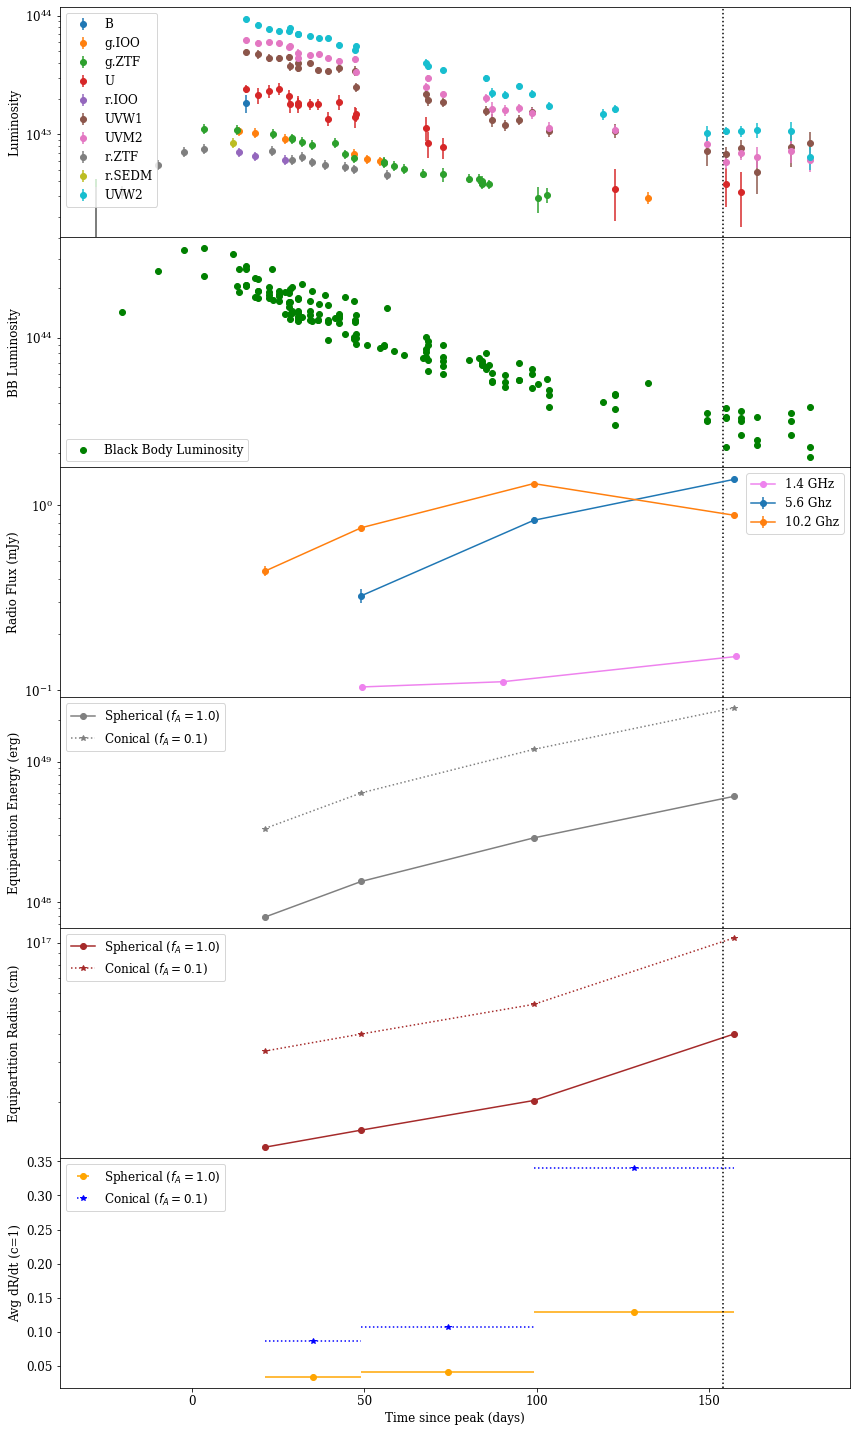

In [18]:
plt.figure(figsize=(12, 20))

ax1 = plt.subplot(611)

# Plot luminosity

for band in bands:
    data = df[df["band"] == band]
    ax1.errorbar(data["#day_since_peak"], data["lum"], yerr=data["err_lum"],  fmt='o', label=band)
    
ax1.set_ylabel("Luminosity", fontsize=12)
ax1.legend(fontsize=12)
ax1.set_yscale("log")
ax1.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":", label="IC191001A")
ax1.tick_params(axis='both', which='major', labelsize=12)

# Plot Black Body Luminosity

ax2 = plt.subplot(612, sharex=ax1)
ax2.scatter(df["#day_since_peak"][df["lum_bb"] > 0], df["lum_bb"][df["lum_bb"] > 0], color="green", label="Black Body Luminosity")

ax2.set_yscale("log")
ax2.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax2.set_ylabel("BB Luminosity", fontsize=12)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)


# Radio Data

ax3 = plt.subplot(613, sharex=ax1)
ax3.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, meerkat_data["flux_mJy"], marker="o", color="violet", label="1.4 GHz")
ax3.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")

for frequency in [5.6, 10.2]:
    data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
    data = data.sort_values("mjd")
    ax3.errorbar(data["mjd"]- t_peak_mjd.mjd, data["flux"],  yerr=data["flux_err"], marker="o", label="{0} Ghz".format(frequency))

ax3.legend(fontsize=12)
ax3.set_ylabel("Radio Flux (mJy)", fontsize=12)
ax3.set_yscale("log")
ax3.tick_params(axis='both', which='major', labelsize=12)

# Equipartition Energy

ax4 = plt.subplot(614, sharex=ax1)

ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux),  marker="o", color="gray", label=r"Spherical ($f_{A}=1.0$)")
ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="gray", label=r"Conical ($f_{A}=0.1$)")
ax4.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax4.set_yscale("log")
ax4.set_ylabel("Equipartition Energy (erg)", fontsize=12)
ax4.legend(fontsize=12)
ax4.tick_params(axis='both', which='major', labelsize=12)

# Equipartition Radius

ax5 = plt.subplot(615, sharex=ax1)
ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux), marker="o", color="brown", label=r"Spherical ($f_{A}=1.0$)")
ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="brown", label=r"Conical ($f_{A}=0.1$)")

ax5.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax5.set_yscale("log")
ax5.set_ylabel("Equipartition Radius (cm)", fontsize=12)
ax5.legend(fontsize=12)
ax5.tick_params(axis='both', which='major', labelsize=12)


# Average Expansion Velocity


ax6 = plt.subplot(616, sharex=ax1)
ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=1.0)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="orange", label=r"Spherical ($f_{A}=1.0$)")

eb1 = ax6.errorbar(offset_times - t_peak_mjd.mjd, [x.value for x in calc_av_expansion(peak_f, peak_flux, f_a=0.1)/(3 * 10 ** 8)], xerr=0.5 * delta_times / u.day, fmt="o", color="blue", marker="*", label=r"Conical ($f_{A}=0.1$)")
eb1[-1][0].set_linestyle(':')

ax6.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax6.set_ylabel(r"Avg dR/dt (c=1)", fontsize=12)
ax6.legend(fontsize=12)

plt.xlabel("Time since peak (days)", fontsize=12)
ax6.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=.0)